In [1]:
# !pip install pandas matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import io
import re

In [80]:
df = pd.concat((
    pd.read_csv(f)
    for f in [
        './data/ble-dump/52hz/4g-500dps/circle.csv',
        './data/ble-dump/52hz/4g-500dps/L.csv',
        './data/ble-dump/52hz/4g-500dps/ghost.csv',
        './data/ble-dump/52hz/4g-500dps/X.csv',
    ]
))
df

,ax,ay,az,gx,gy,gz,name,n
0,10515,-1278,20032,-3389,2207,-4276,circle,0
1,6798,-4066,23078,-1437,2055,-6282,circle,0
2,-285,-7466,24573,961,1270,-7914,circle,0
3,-9796,-9460,26891,3331,202,-8349,circle,0
4,-15006,-9408,24208,5740,-197,-6876,circle,0
...,...,...,...,...,...,...,...,...
633,-1105,-1831,7557,2687,-189,-2575,X,6
634,-1927,-1667,8012,2522,-597,-2449,X,6
635,-997,-1420,8489,2564,-1081,-2287,X,6
636,156,-1651,8030,2659,-650,-2398,X,6


In [81]:
def plot_mov(df, name, n, ax):
    df[
        (df.name == name) & (df.n == n)
    ][['ax', 'ay', 'az', 'gx', 'gy', 'gz']].plot(ax=ax)
    ax.set_title(f'{name} #{n}')

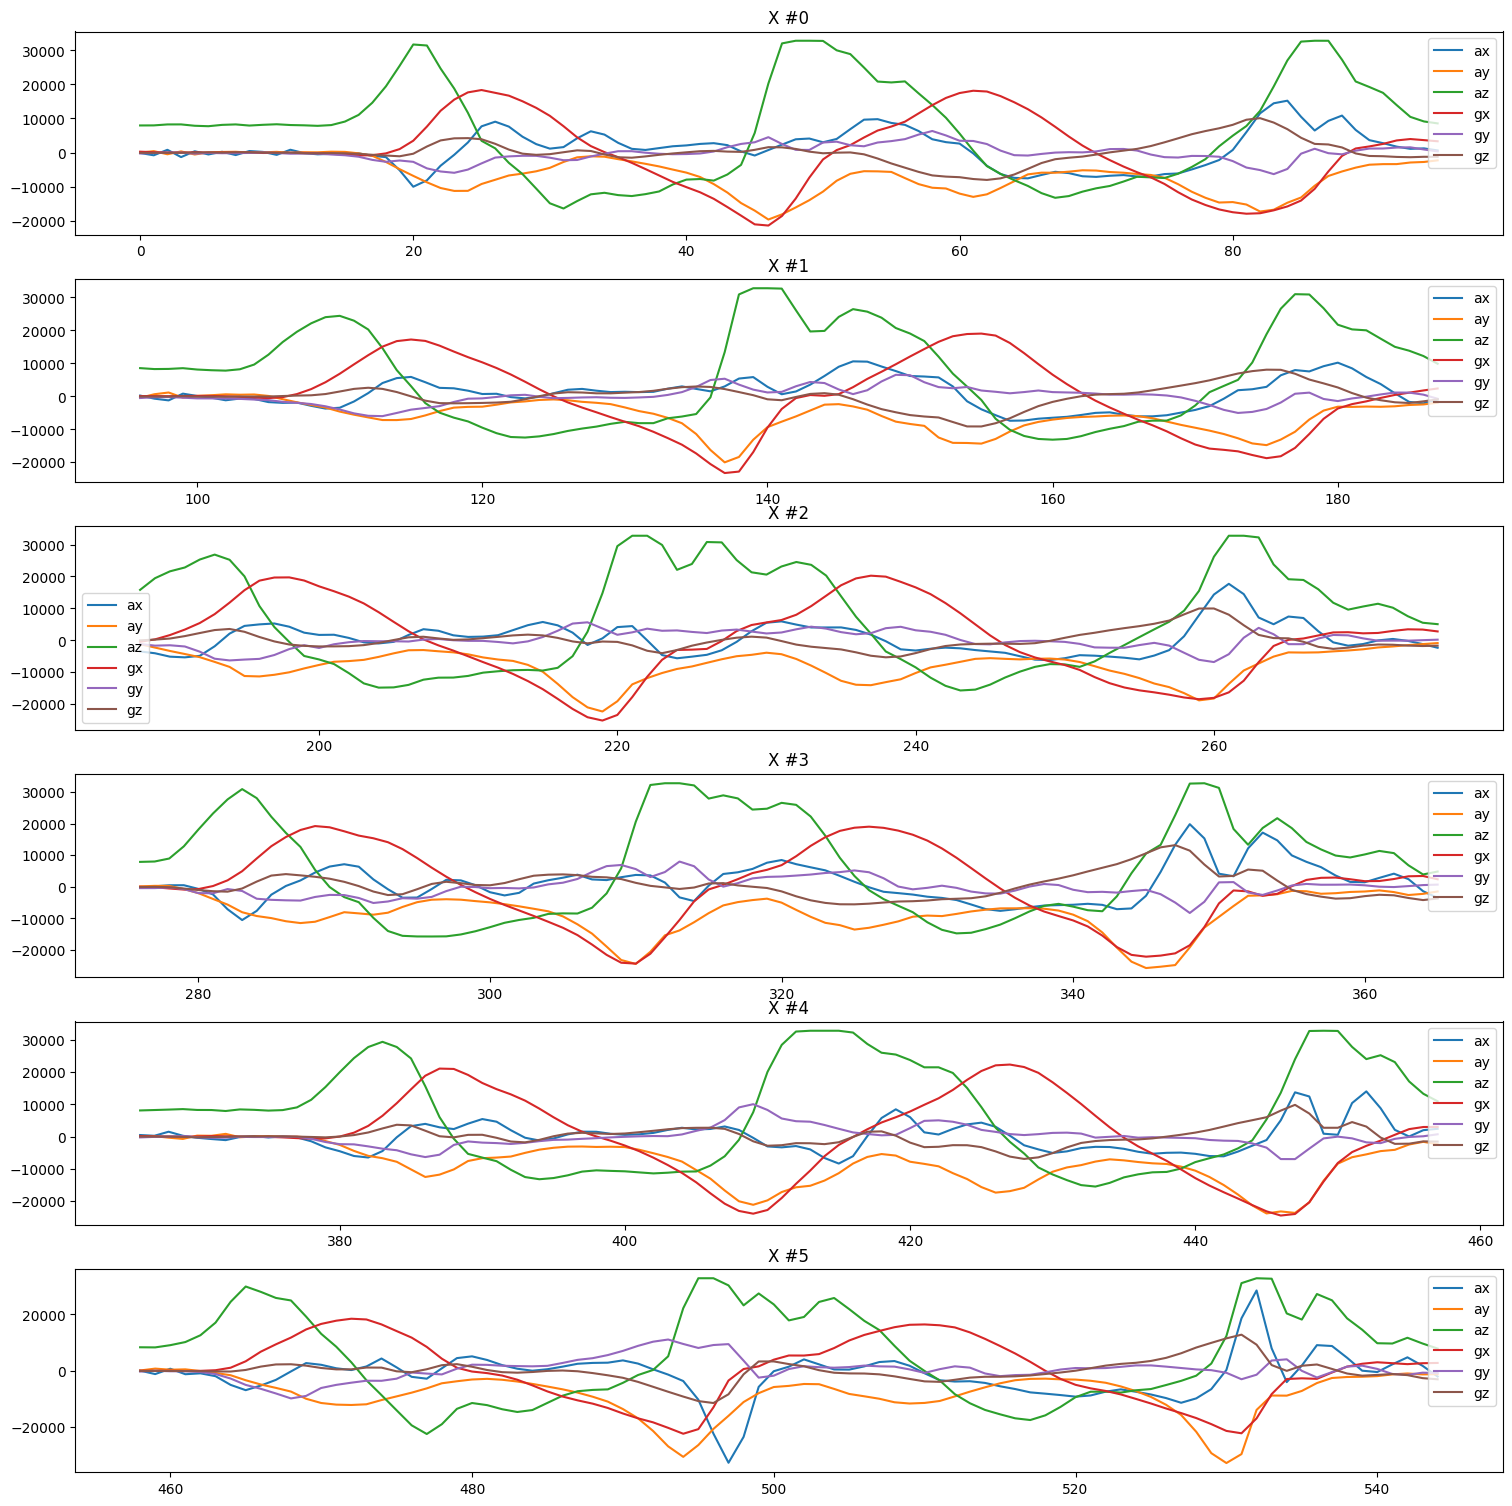

In [89]:
N_EACH = 6

fig, axs = plt.subplots(1 * N_EACH, 1, figsize=(15, 15))
fig.tight_layout()

for i in range(N_EACH):
    plot_mov(df, 'X', i, axs[i])

# for i in range(N_EACH):
#     plot_mov(df, 'X', i, axs[i + N_EACH])



In [34]:
#!pip install dtw-python
# !pip install seaborn dtw-python

In [15]:
import dtw

# https://dynamictimewarping.github.io/python/

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Text(0, 0.5, 'circle #4')

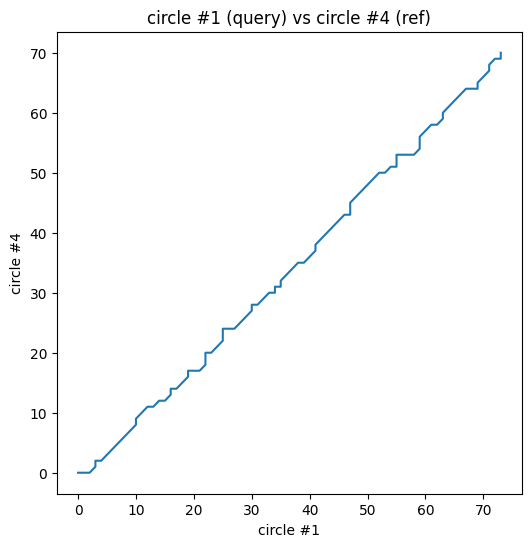

In [74]:
DATA_COLS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

def mov_df(df, name, n):
    return df[(df.name == name) & (df.n == n)][DATA_COLS]

res = dtw.dtw(
    # Query.
    mov_df(df, 'circle', 1),
    # Reference.
    mov_df(df, 'circle', 4)
)
ax = res.plot()
ax.set_title('circle #1 (query) vs circle #4 (ref)')
ax.set_xlabel('circle #1')
ax.set_ylabel('circle #4')

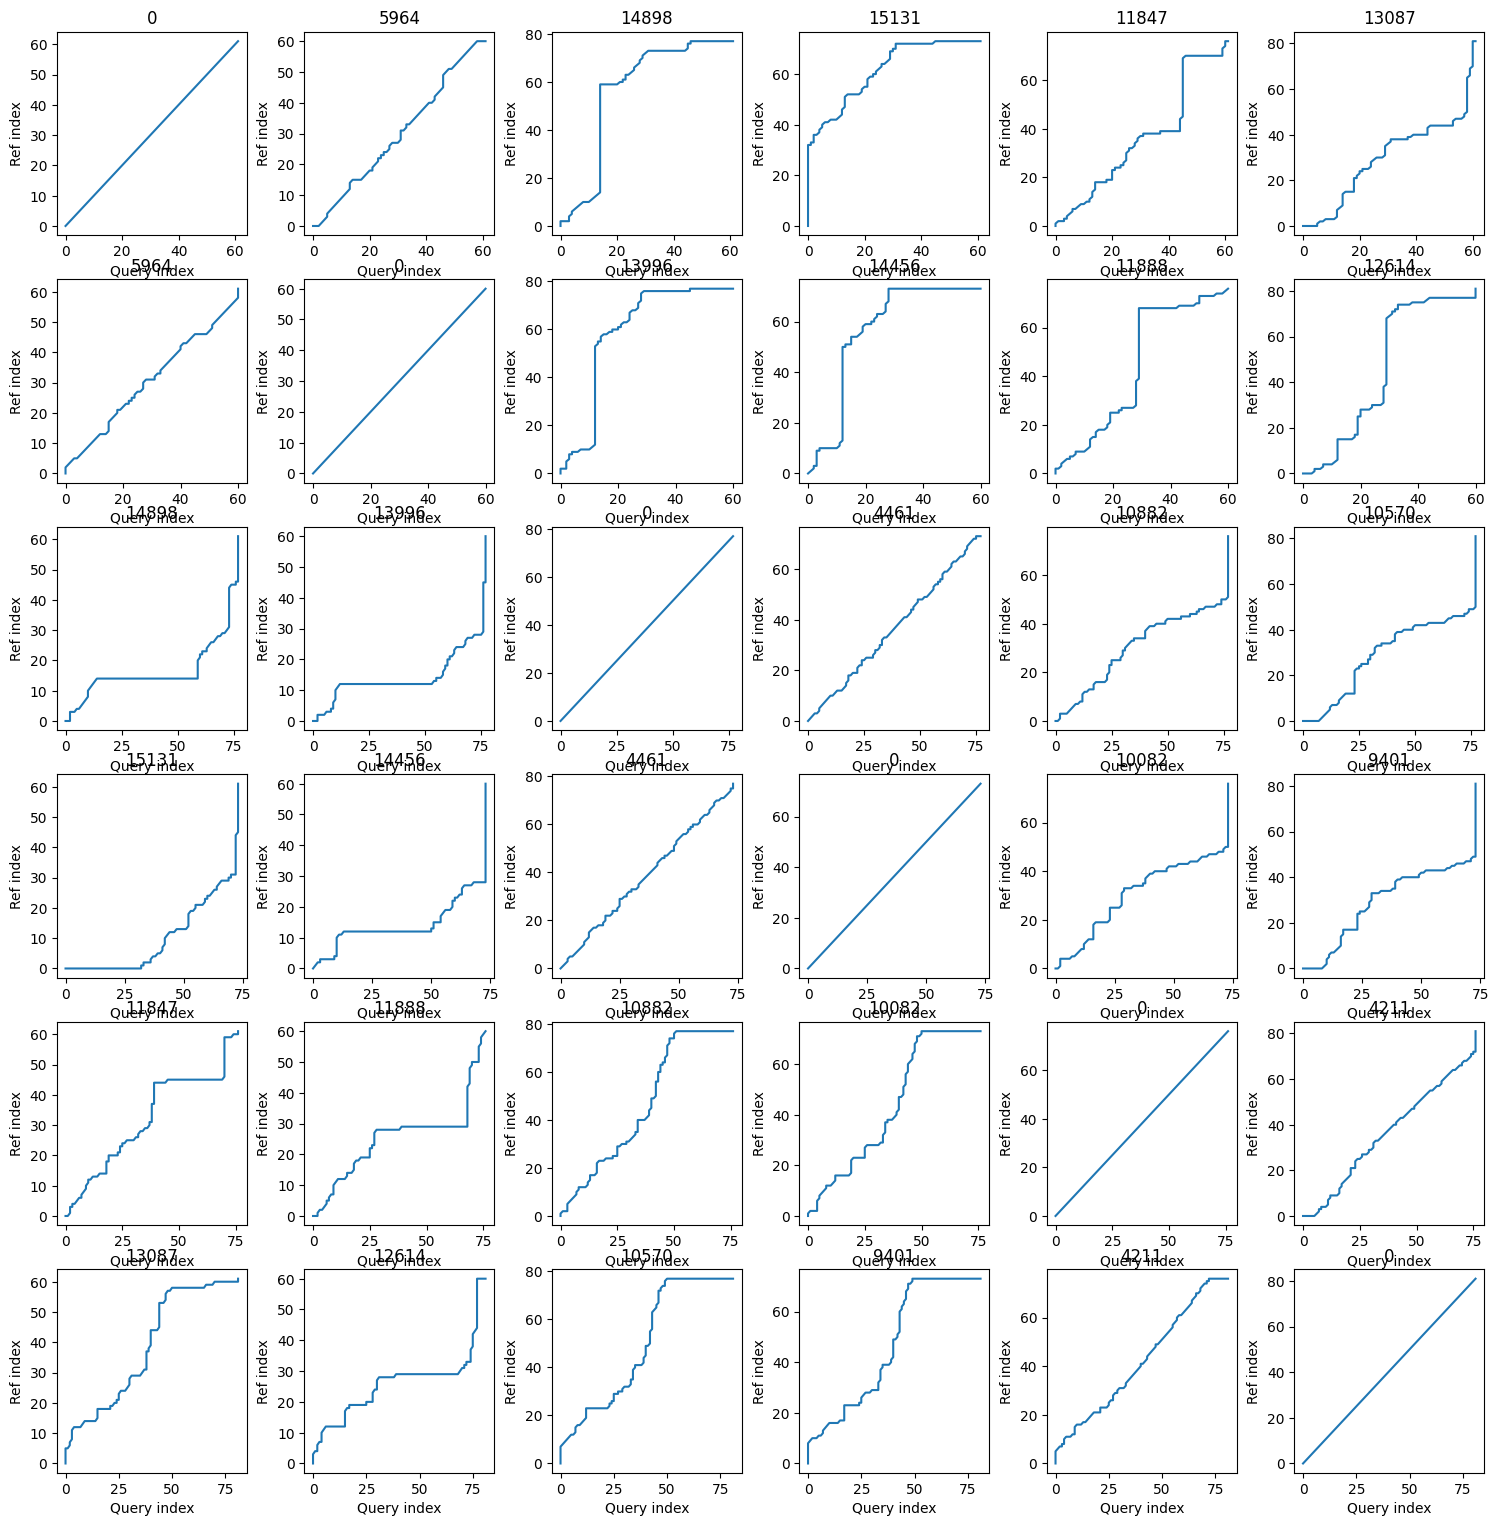

In [132]:
dfs = [mov_df(df, 'L', i) for i in range(2)] + \
      [mov_df(df, 'circle', i) for i in range(2)] + \
      [mov_df(df, 'ghost', i) for i in range(2)]

# [mov_df(df, 'double-circle', i) for i in range(2)] + \

fig, axs = plt.subplots(len(dfs), len(dfs), figsize=(15, 15))
fig.tight_layout()
for i, df1 in enumerate(dfs):
    for j, df2 in enumerate(dfs):
        ax = axs[i][j]
        align = dtw.dtw(df1, df2) 
        # try:
        #     align = dtw.dtw(df1, df2, window_type="sakoechiba", window_args={'window_size': 20})
        # except ValueError:
        #     continue
        # https://github.com/DynamicTimeWarping/dtw-python/blob/56d2e09dd4409f2d7bafb465889d696a25ebdd2c/dtw/dtwPlot.py#L79
        ax.plot(align.index1, align.index2)
        ax.set_xlabel("Query index")
        ax.set_ylabel("Ref index")
        ax.set_title(f'{int(align.normalizedDistance)}')

In [133]:
import itertools

keys = [k for k, v in df.groupby(['name', 'n'])]

def k_dist(k1, k2):
    return dtw.dtw(mov_df(df, *k1), mov_df(df, *k2)).normalizedDistance
    # try:
    #     return dtw.dtw(mov_df(df, *k1), mov_df(df, *k2), window_type="sakoechiba", window_args={'window_size': 20}).normalizedDistance
    # except ValueError as e:
    #     return 20e3

def name(k):
    s, n = k
    return f'{s}_{n}'

records = [{
    'k1': name(k1),
    'k2': name(k2),
    'same_gesture': k1[0] == k2[0],
    'dist': k_dist(k1, k2),
    }
    for a, b in itertools.combinations_with_replacement(keys, 2)
    for k1, k2 in [(a, b), (b, a)]
    if k1 != k2
]

dist_matrix = pd.DataFrame.from_records(records)

In [134]:
dist_df = dist_matrix.pivot(index='k1', columns='k2', values='dist').fillna(0.0)

<Axes: xlabel='k2', ylabel='k1'>

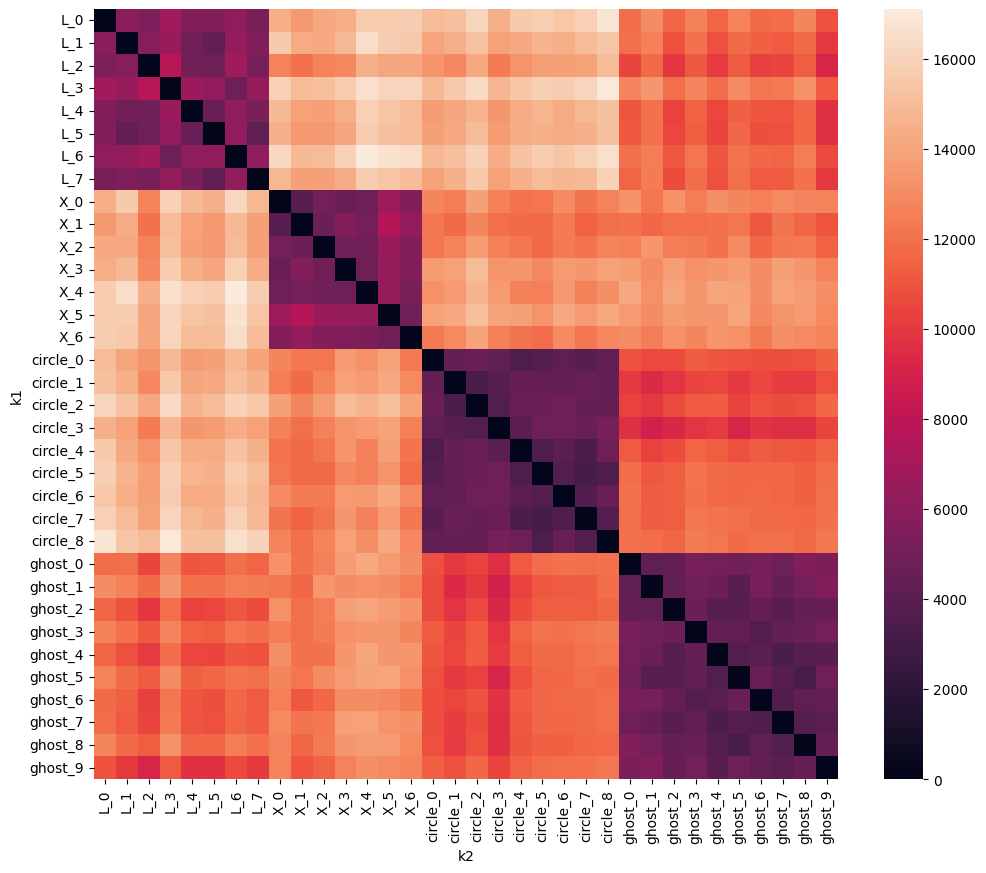

In [135]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(12,10))
sns.heatmap(dist_df, ax=ax)

In [136]:
# Which row is the min dist to circle_0?
dist_df.columns[dist_df['circle_0'].argmin()]

'circle_0'

same_gesture
False    [[Axes(0.125,0.11;0.775x0.77)]]
True     [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

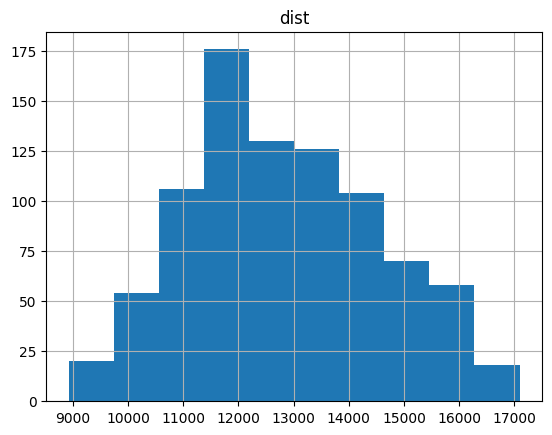

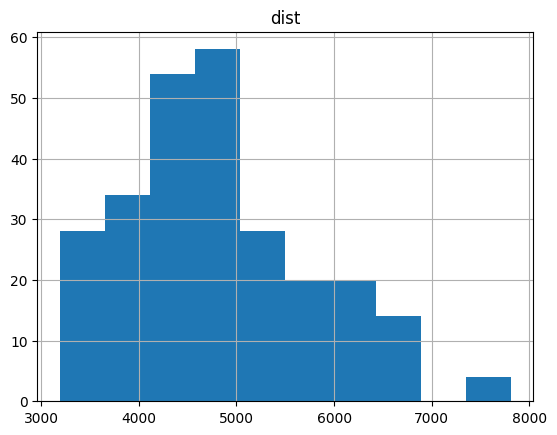

In [137]:
dist_matrix.groupby('same_gesture').hist('dist')